In [71]:
import pandas as pd
import numpy as np
import os
from functools import reduce
import matplotlib.pyplot as plt

% matplotlib inline

In [222]:
def clean_raw_data(df):
    df.columns = df.iloc[0]
    df.drop(0, inplace=True)
    df.drop(["Id", "Geography"], axis=1, inplace=True)
    cols = df.columns
    cols = [x for x in cols if "Margin of Error" in x]
    df.drop(cols, axis=1, inplace=True)
    df.rename(columns={col: col.replace("Estimate; Total:", "Total") for col in df.columns}, inplace=True)
    df.rename(columns={col: col.replace("Estimate: - ", "") for col in df.columns}, inplace=True)
    df.rename(columns={col: col.replace("Estimate; ", "") for col in df.columns}, inplace=True)
    df.rename(columns={col: col.replace("Id2", "Id") for col in df.columns}, inplace=True)
    df.rename(columns={col: col.replace("Total - ", "") for col in df.columns}, inplace=True)
    df.sort_values("Id", inplace=True)
    
    df = df.astype(float)
    df = df[df["Total"] != 0]
    df["BLOCK"] = df["Id"].astype(int).astype(str)
    df.drop("Id", axis=1, inplace=True)
    
    cols = [c for c in df .columns if c not in ["BLOCK"]]
    if len(cols) == 1:
        df = df.set_index("BLOCK")
        return df
    df2 = df[cols].apply(lambda row: row / row["Total"], axis=1)
    df2["BLOCK"] = df["BLOCK"].astype(int).astype(str)
    df2 = df2.set_index("BLOCK").drop("Total", axis=1)
    return df2

def clean_list_raw_data(dfs):
    cleaned_dfs = []
    for df in dfs:
        cleaned_dfs.append(clean_raw_data(df.copy()))
        
    columns = [x.columns[0] for x in cleaned_dfs]
    indexes = [x.index for x in cleaned_dfs]
    indexes = list(set(indexes[0]).intersection(*indexes[:1]))
    cleaned_dfs = [x.ix[indexes].sort_index() for x in cleaned_dfs]
    assert len(set([x.shape[0] for x in cleaned_dfs])) == 1
    results = pd.concat(cleaned_dfs, axis=1)
        
    return results, columns

def compile_county_data(folder):
    my_data = []
    for file in os.listdir(folder):
        if file.endswith("with_ann.csv"):
            my_data.append(pd.read_csv(os.path.join(folder, file)))
    results, columns = clean_list_raw_data(my_data)
#     results.rename({'Id': "BLOCK"}, axis=1, inplace=True)
#     results["BLOCK"] = results["BLOCK"].apply(int).apply(str)
    return results, columns

In [223]:
census, multicol_columns = compile_county_data("data/census_data")
census.to_csv("data/census_data.csv")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [133]:
def compile_crime_data(folder):
    my_data = []
    for file in os.listdir(folder):
        if file.startswith("crime_blocks"):
            my_data.append(pd.read_csv(os.path.join(folder, file)))
    results = pd.concat(my_data, axis=0)
    results.drop("Unnamed: 0", axis=1, inplace=True)
    
    crimes = pd.read_csv('data/NYPD_Complaint_Data_Historic.csv')
    assert len(set(crimes["CMPLNT_NUM"])) == len(list(crimes["CMPLNT_NUM"]))
    crimes = crimes[crimes["CMPLNT_NUM"].isin(list(results["CMPLNT_NUM"]))]

    results.sort_values("CMPLNT_NUM", inplace=True)
    crimes.sort_values("CMPLNT_NUM", inplace=True)
    results.reset_index(inplace=True)
    crimes.reset_index(inplace=True)

    results = pd.concat([results, crimes], axis=1)
    results.drop("index", axis=1, inplace=True)
    results = results.loc[:,~results.columns.duplicated()]
    # Dive down to the block group level, not block
    results["BLOCK"] = results["BLOCK"].apply(str).str[:12]
    
    results["YEAR"] = results['CMPLNT_FR_DT'].str[-4:]
    results = results[results["YEAR"] == '2015']
    results = results.groupby(["BLOCK", "LAW_CAT_CD"])["CMPLNT_NUM"].count().unstack(level=1)
    
    return results

complaints = compile_crime_data("data")
complaints.to_csv('data/NYPD_Complaint_Data_Historic_with_blocks.csv')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# How to deal with the crime data?

Decision call:

- Group by BLOCK
- Group by day (CMPLNT_FR_DT) or year
- Group by offense level (LAW_CAT_CD)

What to do next?

One model per day of week

In [225]:
idx = set(census.index).intersection(complaints.index)
census2 = census.ix[idx].sort_index()
complaints2 = complaints.ix[idx].sort_index()
results = pd.concat([census2, complaints2], axis=1).dropna(axis=0)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [226]:
results["FELONY_perc"] = results["FELONY"] / results["Total"]
results["MISDEMEANOR_perc"] = results["MISDEMEANOR"] / results["Total"]
results["VIOLATION_perc"] = results["VIOLATION"] / results["Total"]

In [214]:
results.to_csv("data/full_dataset.csv", index=False)

In [227]:
results.drop(multicol_columns, axis=1).to_csv("data/drop_first_dataset.csv", index=False)

In [218]:
for c in sorted(results.columns):
    print(c)

$10,000 to $14,999
$100,000 to $124,999
$125,000 to $149,999
$15,000 to $19,999
$150,000 to $199,999
$20,000 to $24,999
$200,000 or more
$25,000 to $29,999
$30,000 to $34,999
$35,000 to $39,999
$40,000 to $44,999
$45,000 to $49,999
$50,000 to $59,999
$60,000 to $74,999
$75,000 to $99,999
10th grade
11th grade
12th grade, no diploma
1st grade
2nd grade
3rd grade
4th grade
5th grade
6th grade
7th grade
8th grade
9th grade
American Indian and Alaska Native alone
Asian alone
Associate's degree
Bachelor's degree
Black or African American alone
Built 1939 or earlier
Built 1940 to 1949
Built 1950 to 1959
Built 1960 to 1969
Built 1970 to 1979
Built 1980 to 1989
Built 1990 to 1999
Built 2000 to 2009
Built 2010 to 2013
Built 2014 or later
Doctorate degree
FELONY
FELONY_perc
Family households:
Family households: - 2-person household
Family households: - 3-person household
Family households: - 4-person household
Family households: - 5-person household
Family households: - 6-person household
Family

In [79]:
def build_full_datasets(census, complaints):
    complaints["YEAR"] = complaints['CMPLNT_FR_DT'].str[-4:]

    misdemeanor = complaints[complaints["LAW_CAT_CD"] == "MISDEMEANOR"].groupby(["BLOCK", "YEAR"])["CMPLNT_NUM"].count()
    felonies = complaints[complaints["LAW_CAT_CD"] == "FELONY"].groupby(["BLOCK", "YEAR"])["CMPLNT_NUM"].count()
    violation = complaints[complaints["LAW_CAT_CD"] == "VIOLATION"].groupby(["BLOCK", "YEAR"])["CMPLNT_NUM"].count()
    
    blocks = list(set(complaints["BLOCK"]))
    dates = list(set(complaints["YEAR"]))
    midx = pd.MultiIndex.from_product([blocks, dates], names=['BLOCK', 'YEAR'])

    misdemeanor = misdemeanor.reindex(midx, fill_value=0).reset_index()
    felonies = felonies.reindex(midx, fill_value=0).reset_index()
    violation = violation.reindex(midx, fill_value=0).reset_index()
    
    # full_misdemeanor = misdemeanor.join(census.set_index(census.BLOCK), on="BLOCK", how="left", lsuffix="_complaints")
    full_misdemeanor = misdemeanor.join(census)
    full_misdemeanor = full_misdemeanor.drop(["BLOCK", "YEAR"], axis=1).dropna(axis=0)
    full_misdemeanor["CMPLNT_NUM"] = full_misdemeanor["CMPLNT_NUM"] / full_misdemeanor["Total"]
    full_misdemeanor.to_csv("data/full_misdemeanor.csv")
    
    # full_felonies = felonies.join(census.set_index(census.BLOCK), on="BLOCK", how="left", lsuffix="_complaints")
    full_felonies = felonies.join(census)
    full_felonies = full_felonies.drop(["BLOCK", "YEAR"], axis=1).dropna(axis=0)
    full_felonies["CMPLNT_NUM"] = full_felonies["CMPLNT_NUM"] / full_felonies["Total"]
    full_felonies.to_csv("data/full_felonies.csv")
    
    # full_violation = violation.join(census.set_index(census.BLOCK), on="BLOCK", how="left", lsuffix="_complaints")
    full_violation = violation.join(census)
    full_violation = full_violation.drop(["BLOCK", "YEAR"], axis=1).dropna(axis=0)
    full_violation["CMPLNT_NUM"] = full_violation["CMPLNT_NUM"] / full_violation["Total"]
    full_violation.to_csv("data/full_violation.csv")

    return full_misdemeanor, full_felonies, full_violation

In [80]:
full_misdemeanor, full_felonies, full_violation = build_full_datasets(census, complaints)

In [82]:
full_felonies

,CMPLNT_NUM,No schooling completed,Nursery school,Kindergarten,1st grade,2nd grade,3rd grade,4th grade,5th grade,6th grade,...,Built 2014 or later,Built 2010 to 2013,Built 2000 to 2009,Built 1990 to 1999,Built 1980 to 1989,Built 1970 to 1979,Built 1960 to 1969,Built 1950 to 1959,Built 1940 to 1949,Built 1939 or earlier


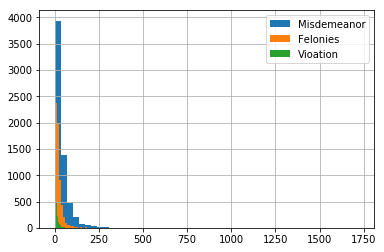

In [273]:
full_misdemeanor["CMPLNT_NUM"].hist(bins=50, label="Misdemeanor")
full_felonies["CMPLNT_NUM"].hist(bins=50, label="Felonies")
full_violation["CMPLNT_NUM"].hist(bins=50, label="Vioation")
plt.legend()
plt.savefig("crime_hist.png")